In [ ]:
import os
import sys
sys.path.append('/home/lakabuli/workspace/LenslessInfoDesign/EncodingInformation/src')
sys.path.append('/home/lakabuli/workspace/LenslessInfoDesign/EncodingInformation/lensless_imager')

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
import numpy as onp
import tensorflow as tf
import tensorflow.keras as tfk

from lensless_helpers import *

from encoding_information import extract_patches
from encoding_information.models import PixelCNN
from encoding_information.models import PoissonNoiseModel
from encoding_information.image_utils import add_noise
from encoding_information import estimate_information

2025-03-29 16:09:58.353032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743289798.371599 1710052 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743289798.377615 1710052 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cleanplots import *
from scipy.stats import linregress
from skimage.color import rgb2gray
from skimage.transform import downscale_local_mean

In [ ]:
save_dir = '/home/lakabuli/workspace/LenslessInfoDesign/experimental_eval/data/'

### Calibration: Converting to Photon Counts

In [4]:
calibration_dir = '/home/lakabuli/cosmos_drive/grayscale_sweep/grayscale_0-255_Mono8/'
rml_dir = calibration_dir + 'rml/'
diffuser_dir = calibration_dir + 'diffusercam/'
gt_dir = calibration_dir + 'ground_truth/'

In [ ]:
rml_calibration_images = []
diffuser_calibration_images = []
gt_calibration_images = []
for idx in range(0, 256):
    rml_image_name = 'img_{}_cam_1.tiff'.format(idx)
    rml_image = plt.imread(rml_dir + rml_image_name)
    rml_calibration_images.append(rml_image)
    diffuser_image_name = 'img_{}_cam_0.tiff'.format(idx)
    diffuser_image = plt.imread(diffuser_dir + diffuser_image_name)
    diffuser_calibration_images.append(diffuser_image)
    gt_image_name = 'img_{}_cam_2.tiff'.format(idx)
    gt_image = plt.imread(gt_dir + gt_image_name)
    gt_calibration_images.append(gt_image)

### Calibration for RML

Fit: 0.02x + 1.46


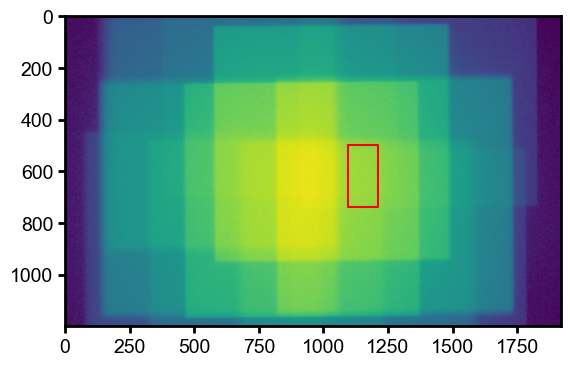

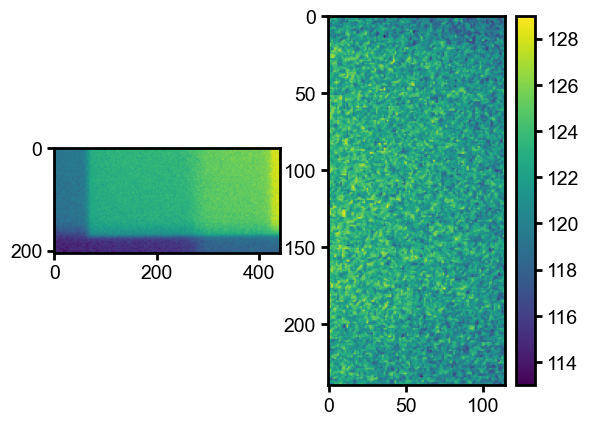

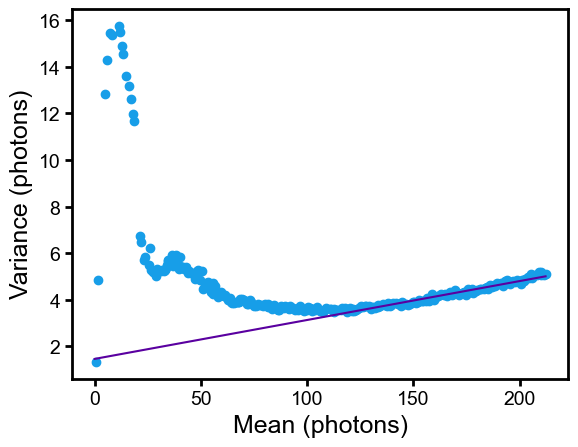

In [ ]:
calibration_images = rml_calibration_images
start_y = 500
end_y = 740
start_x = 1095
end_x = 1210

plt.figure()
plt.imshow(calibration_images[150])
plt.plot([start_x, end_x, end_x, start_x, start_x], [start_y, start_y, end_y, end_y, start_y], 'r-')
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(calibration_images[150][start_x - 100:end_x + 100, start_y - 100:end_y + 100])
plt.subplot(1, 2, 2)
plt.imshow(calibration_images[150][start_y:end_y, start_x:end_x])
plt.colorbar()

means = []
stds = []
for idx, img in enumerate(calibration_images):
    region = img[start_y:end_y, start_x:end_x]
    mean = np.mean(region)
    std = np.std(region)
    means.append(mean)
    stds.append(std)
means = np.array(means)
vars = np.array(stds) ** 2

start_fit = 150
end_fit = 250
fig, ax = plt.subplots()
ax.plot(means, vars, 'o')
ax.set_xlabel('Mean (photons)')
ax.set_ylabel('Variance (photons)')
slope, intercept, r_value, p_value, std_err = linregress(means[start_fit:end_fit], vars[start_fit:end_fit])
x = np.linspace(0, np.max(means), 100)
y = slope * x + intercept
ax.plot(x, y, label=f'Fit: {slope:.2f}x + {intercept:.2f}')

print(f'Fit: {slope:.2f}x + {intercept:.2f}')
rml_slope = slope
rml_intercept = intercept
np.save(save_dir + 'rml_slope_and_intercept.npy', np.array([rml_slope, rml_intercept]))

### Calibration for DiffuserCam

Fit: 0.03x + 0.36


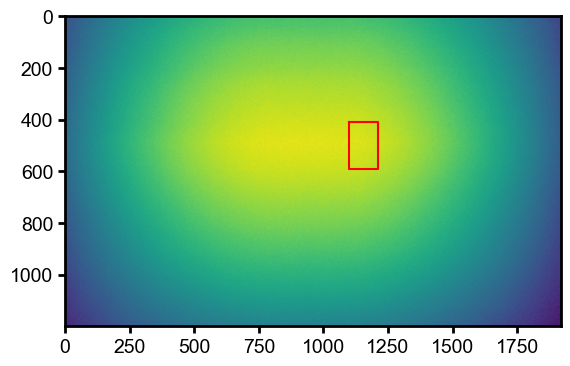

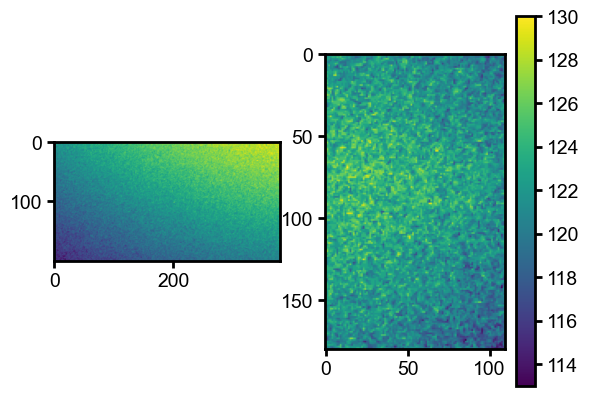

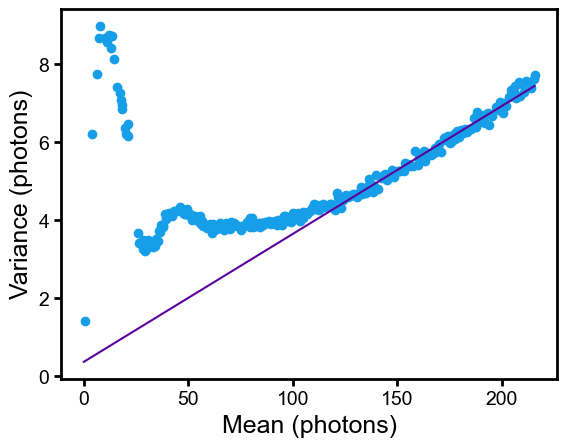

In [ ]:
calibration_images = diffuser_calibration_images
start_y = 410
end_y = 590
start_x = 1100
end_x = 1210

plt.figure()
plt.imshow(calibration_images[150])
plt.plot([start_x, end_x, end_x, start_x, start_x], [start_y, start_y, end_y, end_y, start_y], 'r-')
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(calibration_images[150][start_x - 100:end_x + 100, start_y - 100:end_y + 100])
plt.subplot(1, 2, 2)
plt.imshow(calibration_images[150][start_y:end_y, start_x:end_x])
plt.colorbar()

means = []
stds = []
for idx, img in enumerate(calibration_images):
    region = img[start_y:end_y, start_x:end_x]
    mean = np.mean(region)
    std = np.std(region)
    means.append(mean)
    stds.append(std)
means = np.array(means)
vars = np.array(stds) ** 2

start_fit = 150
end_fit = 250
fig, ax = plt.subplots()
ax.plot(means, vars, 'o')
ax.set_xlabel('Mean (photons)')
ax.set_ylabel('Variance (photons)')
slope, intercept, r_value, p_value, std_err = linregress(means[start_fit:end_fit], vars[start_fit:end_fit])
x = np.linspace(0, np.max(means), 100)
y = slope * x + intercept
ax.plot(x, y, label=f'Fit: {slope:.2f}x + {intercept:.2f}')

print(f'Fit: {slope:.2f}x + {intercept:.2f}')

diffuser_slope = slope
diffuser_intercept = intercept
np.save(save_dir + 'diffuser_slope_and_intercept.npy', np.array([diffuser_slope, diffuser_intercept]))

### Calibration for Ground Truth Images

Fit: 0.05x + 0.01


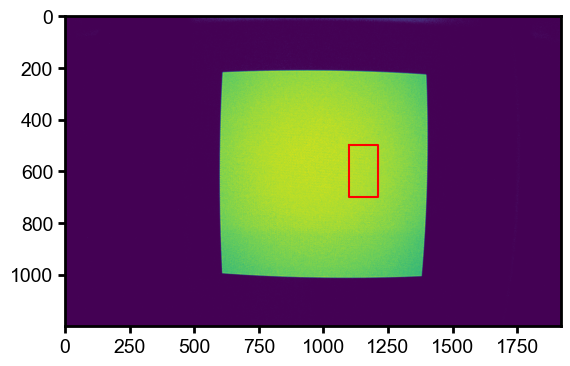

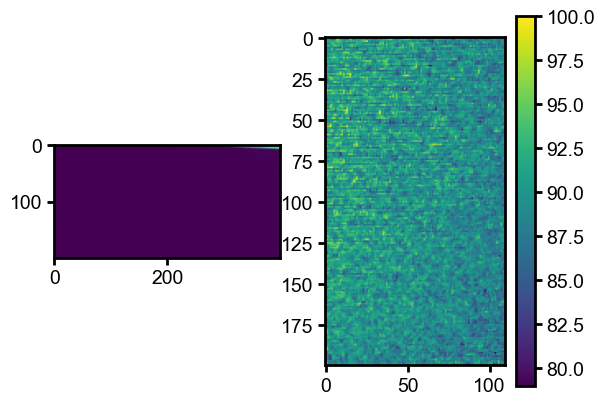

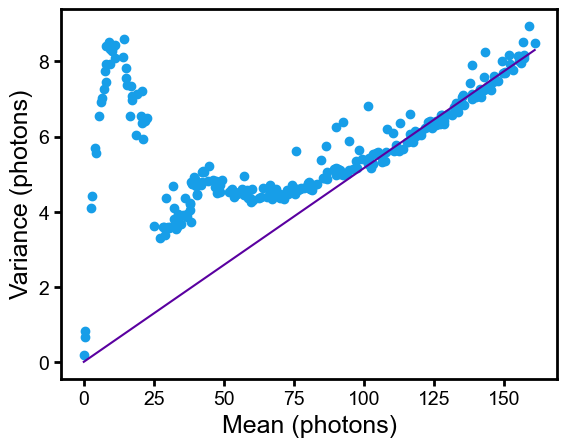

In [ ]:
calibration_images = gt_calibration_images
start_y = 500
end_y = 700
start_x = 1100
end_x = 1210

plt.figure()
plt.imshow(calibration_images[150])
plt.plot([start_x, end_x, end_x, start_x, start_x], [start_y, start_y, end_y, end_y, start_y], 'r-')
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(calibration_images[150][start_x - 100:end_x + 100, start_y - 100:end_y + 100])
plt.subplot(1, 2, 2)
plt.imshow(calibration_images[150][start_y:end_y, start_x:end_x])
plt.colorbar()

means = []
stds = []
for idx, img in enumerate(calibration_images):
    region = img[start_y:end_y, start_x:end_x]
    mean = np.mean(region)
    std = np.std(region)
    means.append(mean)
    stds.append(std)
means = np.array(means)
vars = np.array(stds) ** 2

start_fit = 175
end_fit = 250
fig, ax = plt.subplots()
ax.plot(means, vars, 'o')
ax.set_xlabel('Mean (photons)')
ax.set_ylabel('Variance (photons)')
slope, intercept, r_value, p_value, std_err = linregress(means[start_fit:end_fit], vars[start_fit:end_fit])
x = np.linspace(0, np.max(means), 100)
y = slope * x + intercept
ax.plot(x, y, label=f'Fit: {slope:.2f}x + {intercept:.2f}')

print(f'Fit: {slope:.2f}x + {intercept:.2f}')

gt_slope = slope
gt_intercept = intercept
np.save(save_dir + 'gt_slope_and_intercept.npy', np.array([gt_slope, gt_intercept]))

### Measurement Conversion

In [9]:
def convert_image_to_photons(image, slope, intercept):
    return (image - intercept) / slope

In [ ]:
measurement_dir = '/home/lakabuli/cosmos_drive/0-25k/'
rml_dir = measurement_dir + 'rml/'
diffuser_dir = measurement_dir + 'diffusercam/'
gt_dir = measurement_dir + 'ground_truth/'

In [ ]:
train_set_index_start = 1000
test_set_index_start = 0
num_test_images = 1000
num_train_images = 10000

train_img_idx = 5
mean_photon_count = 500

(1200, 1920, 3) uint8
(800, 800) float32
(800, 800) float64 0.0 3162.2229072507257 1147.334338723239 675.2062366478962
500.0


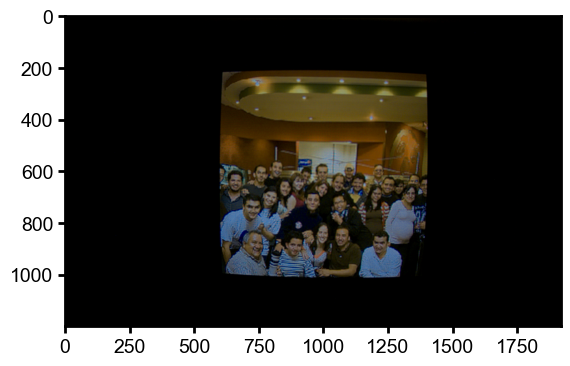

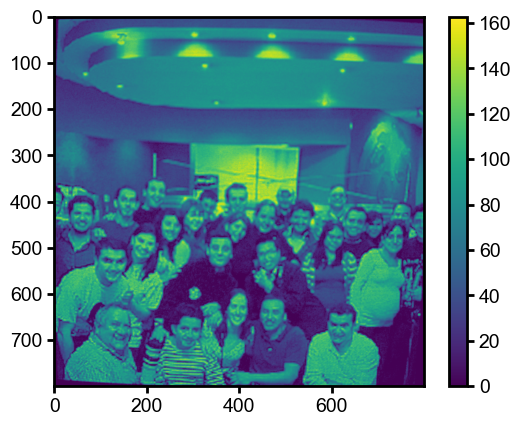

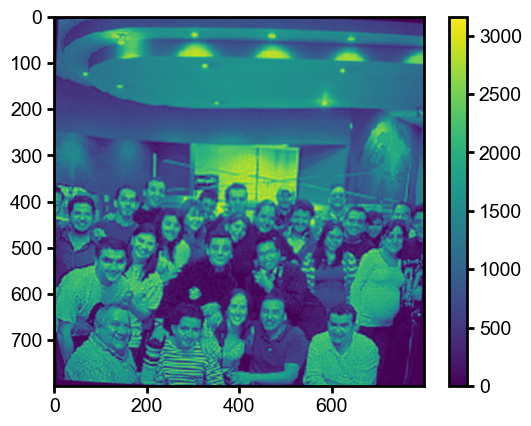

In [ ]:
image_name = 'img_{}_cam_2.tiff'.format(train_set_index_start + train_img_idx)
image = plt.imread(gt_dir + image_name)
plt.imshow(image)
print(image.shape, image.dtype)
image = rgb2gray(image).astype(np.float32)
image = image * 255.0
image = image[210:1010, 600:1400]
plt.figure()
plt.imshow(image)
plt.colorbar()
print(image.shape, image.dtype)
image_photons = convert_image_to_photons(image, gt_slope, gt_intercept)
image_photons = np.clip(image_photons, 0, None)
plt.figure()
plt.imshow(image_photons)
plt.colorbar()
print(image_photons.shape, image_photons.dtype, np.min(image_photons), np.max(image_photons), np.mean(image_photons), np.std(image_photons))
image_photons = downscale_local_mean(image_photons, (16, 16))
image_photons = image_photons / np.mean(image_photons)
image_photons = image_photons * mean_photon_count
print(np.mean(image_photons))

(1200, 1920, 3) uint8
(1200, 1200) float32
(1200, 1200) float64 1605.2821940331607 5927.249240394201 4417.101209641229 867.8181869033622
500.0000000000001


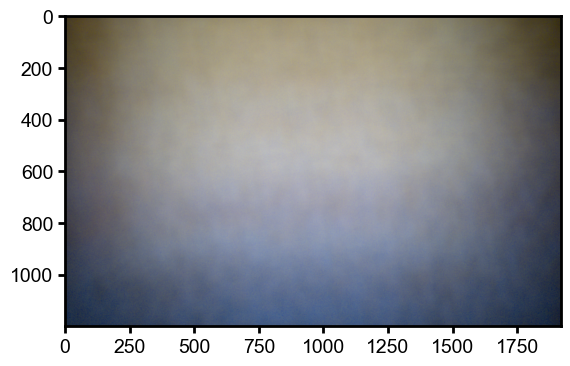

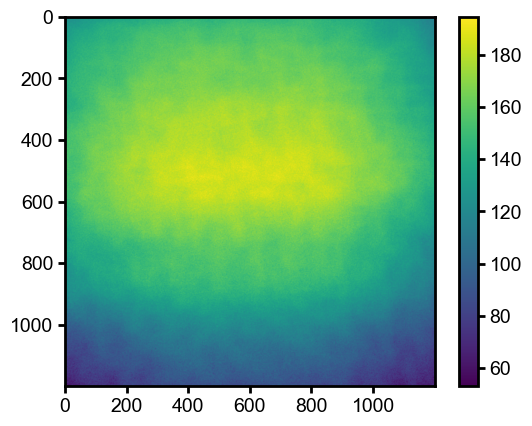

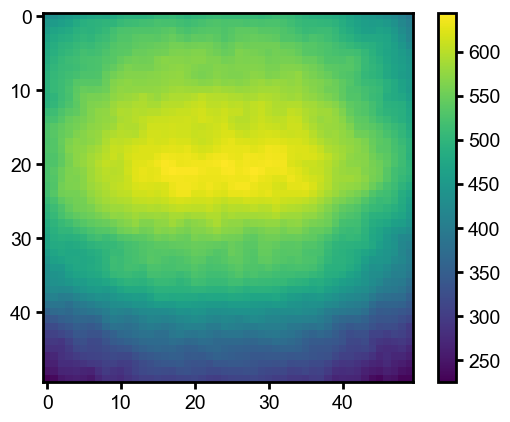

In [ ]:
image_name = 'img_{}_cam_0.tiff'.format(train_set_index_start + train_img_idx)
image = plt.imread(diffuser_dir + image_name)
plt.imshow(image)
print(image.shape, image.dtype)
image = rgb2gray(image).astype(np.float32)
image = image[:, 360:-360]
image = image * 255.0
plt.figure()
plt.imshow(image)
plt.colorbar()
print(image.shape, image.dtype)
image_photons = convert_image_to_photons(image, diffuser_slope, diffuser_intercept)
image_photons = np.clip(image_photons, 0, None)
print(image_photons.shape, image_photons.dtype, np.min(image_photons), np.max(image_photons), np.mean(image_photons), np.std(image_photons))
image_photons = downscale_local_mean(image_photons, (24, 24))
image_photons = image_photons / np.mean(image_photons)
image_photons = image_photons * mean_photon_count
plt.figure()
plt.imshow(image_photons)
plt.colorbar()
print(np.mean(image_photons))

(1200, 1920, 3) uint8
(1200, 1200) float32
(1200, 1200) float64 1.728545976799652 9642.045883866112 5149.387411058343 1659.162014233287
500.0


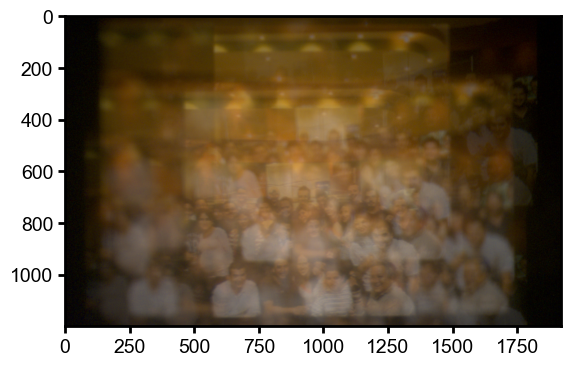

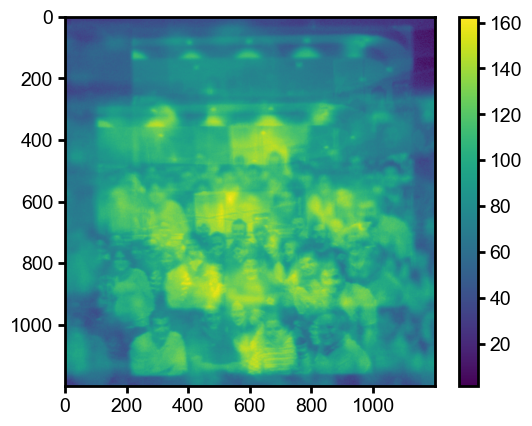

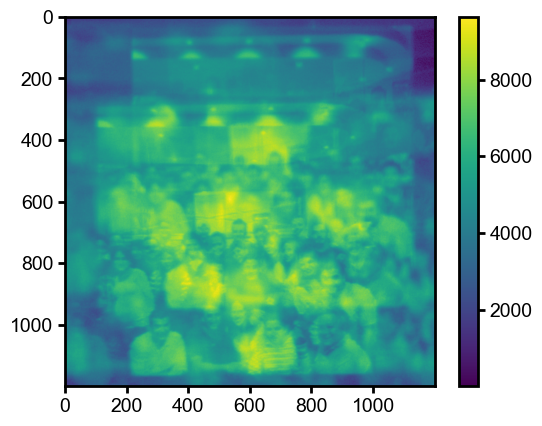

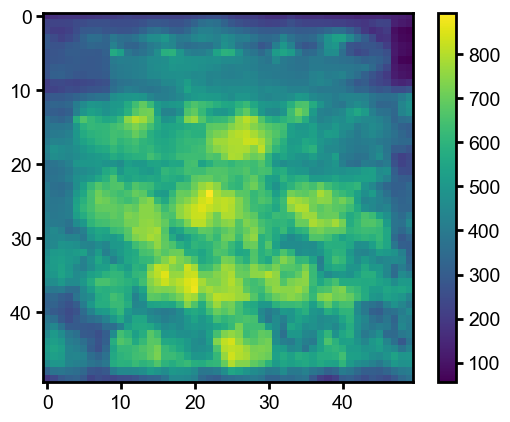

In [ ]:
image_name = 'img_{}_cam_1.tiff'.format(train_set_index_start + train_img_idx)
image = plt.imread(rml_dir + image_name)
plt.imshow(image)
print(image.shape, image.dtype)
image = rgb2gray(image).astype(np.float32)
image = image[:, 360:-360]
image = image * 255.0
plt.figure()
plt.imshow(image)
plt.colorbar()
print(image.shape, image.dtype)
image_photons = convert_image_to_photons(image, rml_slope, rml_intercept)
image_photons = np.clip(image_photons, 0, None)
plt.figure()
plt.imshow(image_photons)
plt.colorbar()
print(image_photons.shape, image_photons.dtype, np.min(image_photons), np.max(image_photons), np.mean(image_photons), np.std(image_photons))
image_photons = downscale_local_mean(image_photons, (24, 24))
image_photons = image_photons / np.mean(image_photons)
image_photons = image_photons * mean_photon_count
plt.figure()
plt.imshow(image_photons)
plt.colorbar()
print(np.mean(image_photons))